In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime, timedelta, date
from sympy import symbols, solve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
from sklearn.metrics import mean_squared_log_error

## SIRD model in Python 

In [3]:
# SIRD model divided into its equations
def deriv(y, t, N, beta, gamma, rho):
    S, I, R, D= y
    dSdt = -(beta * S * I) / N
    dIdt = ((beta * S * I) / N) - ((gamma+rho)*I)
    dRdt = gamma * I
    dDdt = rho * I
    return dSdt, dIdt, dRdt, dDdt

## Graph SIRD model

In [4]:
def getSIRD(tf, N, i0, beta, gamma, rho, sd):
    t = np.linspace(0, tf, tf)

    y0 = N-i0, i0, 0, 0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, rho))
    S, I, R, D = ret.T


    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta-sd[0], gamma-sd[1], rho-sd[2]))
    Sm, Im, Rm, Dm = ret.T 

    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta+sd[0], gamma+sd[1], rho+sd[2]))
    Sp, Ip, Rp, Dp = ret.T 

    return S,I,R,D

In [28]:
import math
def plotSIRD(ax, tf, N, i0, beta, gamma, rho, ylimit, xlimit, sd, offset, sird_true):
    t = np.linspace(0, tf, tf)

    y0 = N-i0, i0, 0, 0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, rho))
    S, I, R, D = ret.T

    # SD SIR equation
    #ret = odeint(deriv, y0, t, args=(N, beta-sd[0], gamma-sd[1], rho-sd[2]))
    #Sm, Im, Rm, Dm = ret.T 

    # SD SIR equation
    #ret = odeint(deriv, y0, t, args=(N, beta+sd[0], gamma+sd[1], rho+sd[2]))
    #Sp, Ip, Rp, Dp = ret.T 


    # Plotting SIRD data point
    if (sird_true):
        ax.plot(t+offset, D, 'y', alpha=0.5, lw=2, label='Deceased')
    else:
        ax.plot(t+offset, D, alpha=1, lw=2, label='Predicted Cumulative Deaths due to COVID-19')


    # Creating Labels for graph
    ax.set_xlabel('Time / Days')
    ax.set_ylabel('Deceased')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
    ax.set_xlim([xlimit[0], xlimit[1]])
    ax.set_ylim([ylimit[0], ylimit[1]])
    # ax.fill_between(t+offset, Dm, Dp, alpha=0.2, edgecolor='black',  label="Standard Deviation")
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    return D
    

In [6]:
def plotRealData (graph, data, offset, beforeForecast, D, minus, manipulate=False):
    if (manipulate==False):
        deaths = data["cumDeath"].tolist()
        deaths = [x-minus for x in deaths]
    else:
        deaths = data["cumDeath"]-data["cumDeath"].loc[offset]
        deaths = deaths.to_list()
        deaths = [x+minus for x in deaths]
    t = np.linspace(0, 700, 700)
    if (offset != 0):
        graph.plot(t[0:offset], deaths[0:offset], 'r', marker='.', linestyle = 'None')
        graph.plot(t[offset:beforeForecast], deaths[offset:beforeForecast], 'r', marker='x', label="Observed Cumulative Deaths due to COVID-19", linestyle = 'None')
        graph.plot(t[beforeForecast:len(t)], deaths[beforeForecast:len(t)], 'r', marker='.', label="Unseen Cumulative Deaths due to COVID-19", linestyle = 'None')
    else:
        graph.plot(t[0:beforeForecast], deaths[0:beforeForecast], 'r', marker='x', label="Observed Cumulative Deaths due to COVID-19", linestyle = 'None')
        graph.plot(t[beforeForecast:len(t)], deaths[beforeForecast:len(t)], 'r', marker='.', label="Unseen Cumulative Deaths due to COVID-19", linestyle = 'None')
    legend = graph.legend( loc='center left', bbox_to_anchor=(1, 0.5))
    legend.get_frame().set_alpha(0.5)
    return graph
    

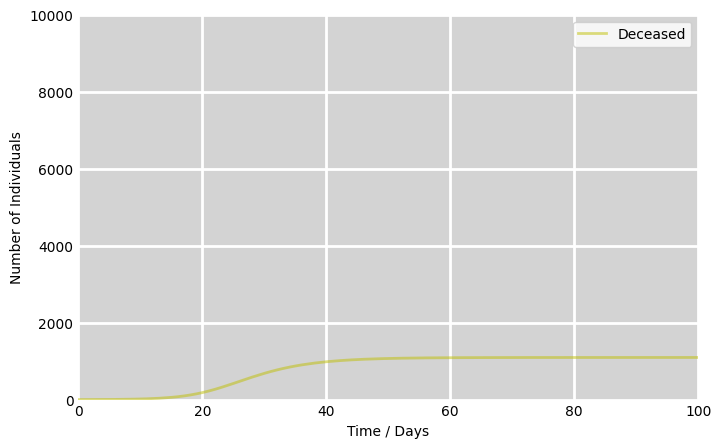

In [29]:
fig, ax1 = plt.subplots(1,1, figsize=(8,5))    
plotSIRD(ax1,300,10000,10,0.5,0.2,0.03,[0,10000],[0,100],None,0,True)
ax1.set_facecolor('lightgrey')
ax1.set_ylabel("Number of Individuals")
ax1.legend()

## Bulk 

In [14]:
def addTime(startDate, t): 
    dates = datetime.strptime(startDate, '%Y-%m-%d').date()
    d = dates+ timedelta(days = t)
    return d.strftime('%Y-%m-%d')
def timeTot(startDate, endDate):
    sD = startDate.split('-')
    sDs = date(int(sD[0]),int(sD[1]),int(sD[2]))
    eD = endDate.split('-')
    eDs = date(int(eD[0]),int(eD[1]),int(eD[2]))
    delta = eDs - sDs
    return delta.days

In [15]:
dataset = {
    'France': {
        'data' : pd.read_csv("../processed_data/cumDeathFrance.csv"),
        'fLock' : ['2020-03-17','2020-05-11'],
        'sLock' : ['2020-10-30','2020-12-15'],
        'pop' : 67413000
             },
    'Italy' : {
        'data' : pd.read_csv("../processed_data/cumDeathItaly.csv"),
        'fLock' : ['2020-03-09','2020-05-18'], 
        'sLock' : ['2020-12-24','2021-01-06'],
        'pop': 59110000
              },
    'Spain' : {
        'data' : pd.read_csv("../processed_data/cumDeathSpain.csv"),
        'fLock' : ['2020-03-14','2020-05-09'], 
        'sLock' : ['2020-11-03','2021-02-03'],
        'pop' : 47420000
              },
    'Germany' : {
        'data' : pd.read_csv("../processed_data/cumDeathGermany.csv"),
        'fLock' : ['2020-03-16','2020-05-30'], 
        'sLock' : ['2020-11-02','2021-03-01'],
        'pop' : 83000000
                },
    'UK' : {
        'data' : pd.read_csv("../processed_data/cumDeathUK.csv"),
        'fLock' : ['2020-03-23','2020-07-04'], 
        'sLock' : ['2020-11-05','2021-03-28'],
        'pop' : 67330000
           },
    'Netherlands' : {
        'data' : pd.read_csv("../processed_data/cumDeathNetherlands.csv"),
        'fLock' : ['2020-03-15', '2020-04-06'],
        'sLock' : ['2020-12-15', '2021-06-05'],
        'pop' : 17606800
            }
}


### Testing MCMC model with ODE SIRD

In [16]:
import math
N = 60000000
i0 = 300
s0 = N-i0
beta = 0.03
gamma = 0.04
rho = 0.11
time = 0
k = i0/s0
# Integrate the SIR equations over the time grid, t.
solution = 0
for time in range(1):
    solution += (i0*(1+k)**(beta/(beta-(gamma)))*(1+k*math.e**(beta-(gamma))*time)**-(beta/(beta-(gamma)))*math.e**((beta-(gamma))*(time)))

print(getSIRD(100,60000000,300,0.03,0.04,0.11,[0.01,0.03,0.04])[3][1])
print(solution)

31.39233857398158
299.99550002250004


## First Lockdown

### Goodness of Fit

In [17]:

country_names = ['Netherlands', 'France','Germany','Italy','Spain','UK']
values = []
for country in country_names:
    pop = dataset[country]['pop']
    df_observed_data = dataset[country]['data']
    df_parameters = pd.read_csv('mcmc_data/'+country+"/fLock_before.csv")

    # Get beginning of lockdown date
    startDate = dataset[country]['fLock'][0]
    # Get the index of the date
    startDate = df_observed_data[df_observed_data['date'] == startDate].index

    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']

    obs_deaths = df_observed_data["cumDeath"].tolist()
    init_death = obs_deaths[startDate[0]-11]
    obs_deaths = obs_deaths[startDate[0]-10:startDate[0]+5]

    # Plug in parameters to the SIRD differential equation
    sird = getSIRD(60,pop, df_parameters.loc[3][1],df_parameters.loc[0][1],df_parameters.loc[1][1],df_parameters.loc[2][1], [df_parameters.loc[0][2], df_parameters.loc[1][2], df_parameters.loc[2][2]] )

    pred_deaths = sird[3]
    pred_deaths = pred_deaths[0:15] + init_death

    # Calculate R2 and RMSE
    r2 = r2_score(obs_deaths, pred_deaths)
    rmse =  np.sqrt(mean_squared_log_error(obs_deaths, pred_deaths))

    n = len(obs_deaths)
    k = 4 # number of parameters (beta and gamma)
    rss = np.sum((obs_deaths-pred_deaths)**2)
    aic = n * np.log(rss/n) + 2 * k
    result = [country,r2,rmse,aic]
    values.append(result)
df = pd.DataFrame(values, columns=['Country','R-Squared (R2)','Root Mean Squared Error (RMSE)','AIC'])
df

,Country,R-Squared (R2),Root Mean Squared Error (RMSE),AIC
0,Netherlands,0.951836,0.302394,55.578193
1,France,0.945472,0.638825,115.925932
2,Germany,0.978213,0.240288,93.444527
3,Italy,0.954967,0.143108,139.996321
4,Spain,0.973054,0.551105,128.455679
5,UK,0.976185,0.093086,196.701482


In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
from sklearn.metrics import mean_squared_log_error

country_names = ['Netherlands', 'France','Germany','Italy','Spain','UK']
values = []
for country in country_names:
    pop = dataset[country]['pop']
    df_real = dataset[country]['data']
    df_param = pd.read_csv('mcmc_data/'+country+"/fLock_after.csv")

    # Get beginning of lockdown date
    startDate = dataset[country]['fLock'][0]

    # Get the index of the date
    startDate = df_real[df_real['date'] == startDate].index

    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']

    # Plug in parameters to the SIRD differential equation
    sird = getSIRD(30,pop, df_param.loc[3][1],df_param.loc[0][1],df_param.loc[1][1],df_param.loc[2][1], [df_param.loc[0][2], df_param.loc[1][2], df_param.loc[2][2]] )

    deaths = df_real["cumDeath"].tolist()
    init_death = deaths[startDate[0]+4]
    deaths = deaths[startDate[0]+5:startDate[0]+20]
    
    deaths_predicted = sird[3]
    deaths_predicted = deaths_predicted[0:15] + init_death
    
    r2 = r2_score(deaths, deaths_predicted)
    rmse =  np.sqrt(mean_squared_log_error(deaths, deaths_predicted))

    n = len(deaths)
    k = 4 # number of parameters (beta and gamma)
    rss = np.sum((deaths-deaths_predicted)**2)
    aic = n * np.log(rss/n) + 2 * k
    result = [country,r2,rmse,aic]
    values.append(result)
df = pd.DataFrame(values, columns=['Country','R-Squared (R2)','Root Mean Squared Error (RMSE)','AIC'])
df

,Country,R-Squared (R2),Root Mean Squared Error (RMSE),AIC
0,Netherlands,0.997547,0.091680,100.505444
1,France,0.970962,0.115309,188.163492
2,Germany,0.995129,0.062086,139.833575
3,Italy,0.996927,0.050226,158.059538
4,Spain,0.996398,0.072397,167.834052
5,UK,0.997637,0.067704,238.743425


### Graph

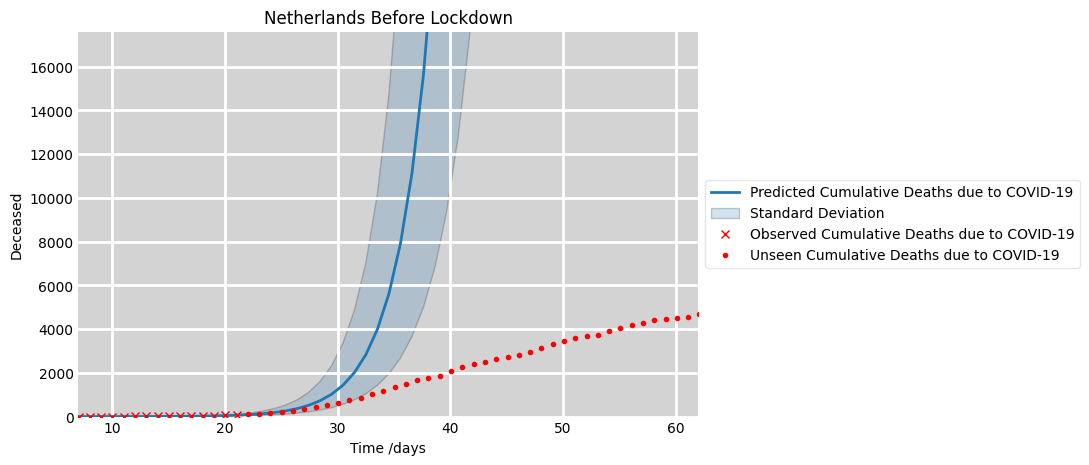

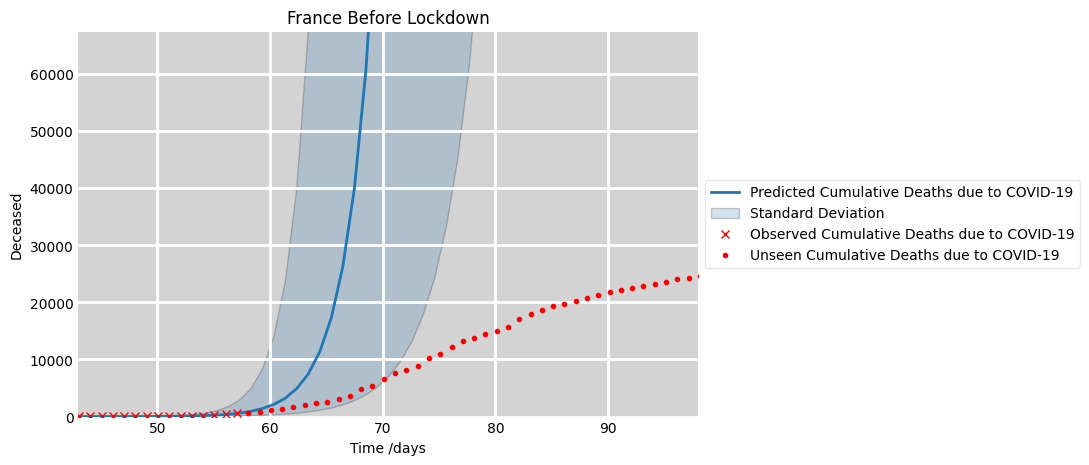

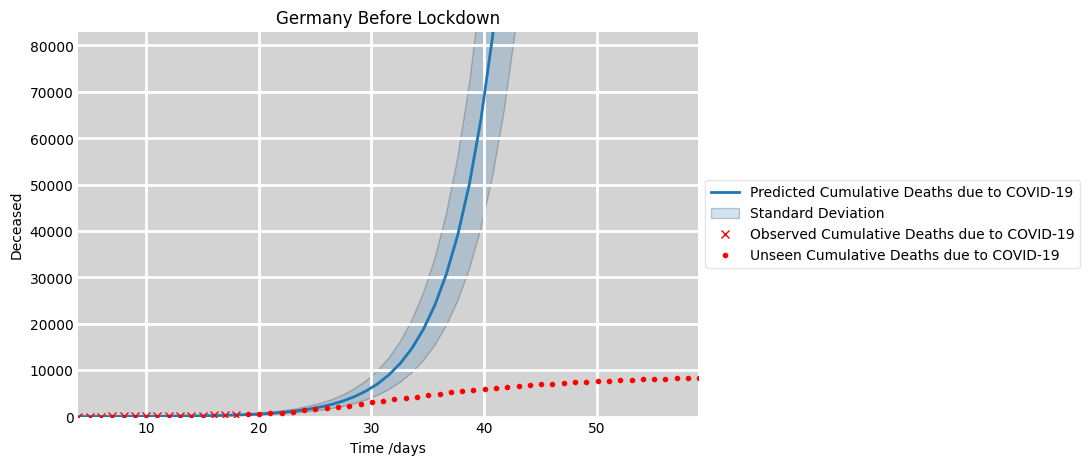

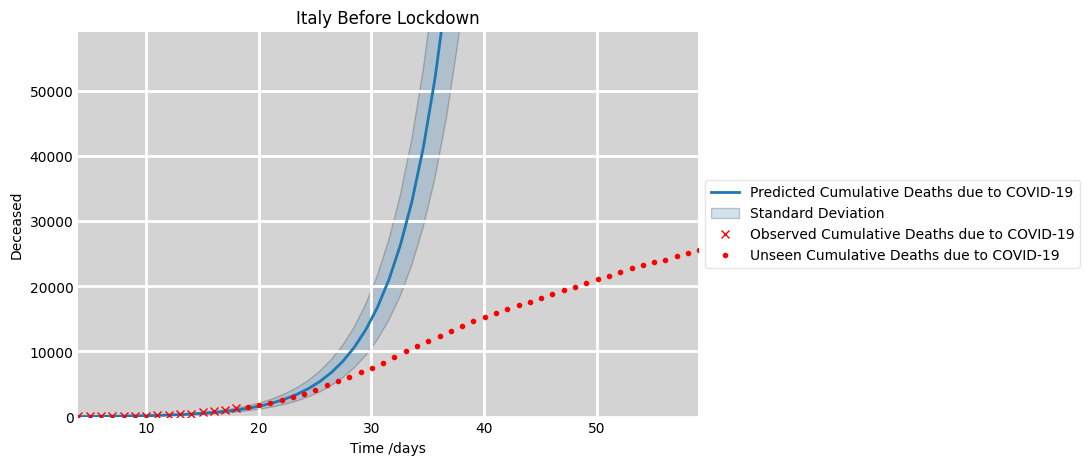

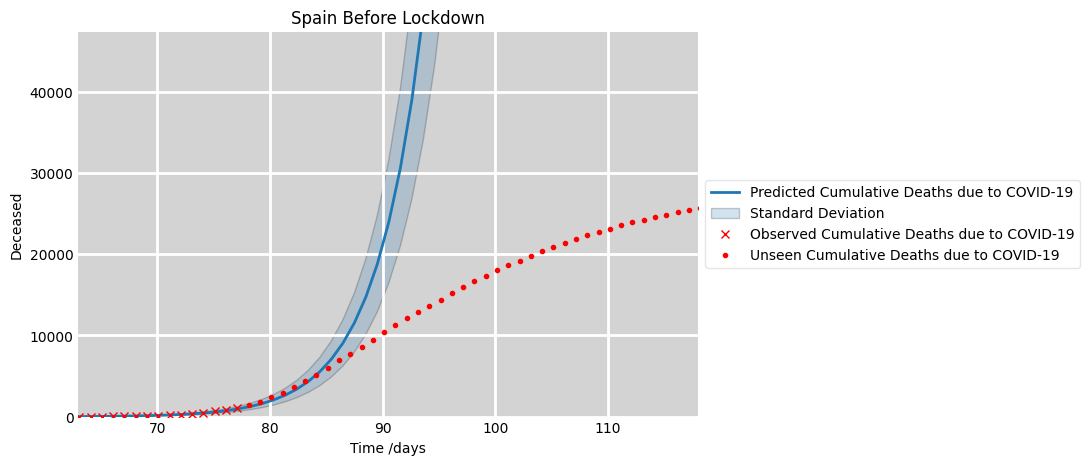

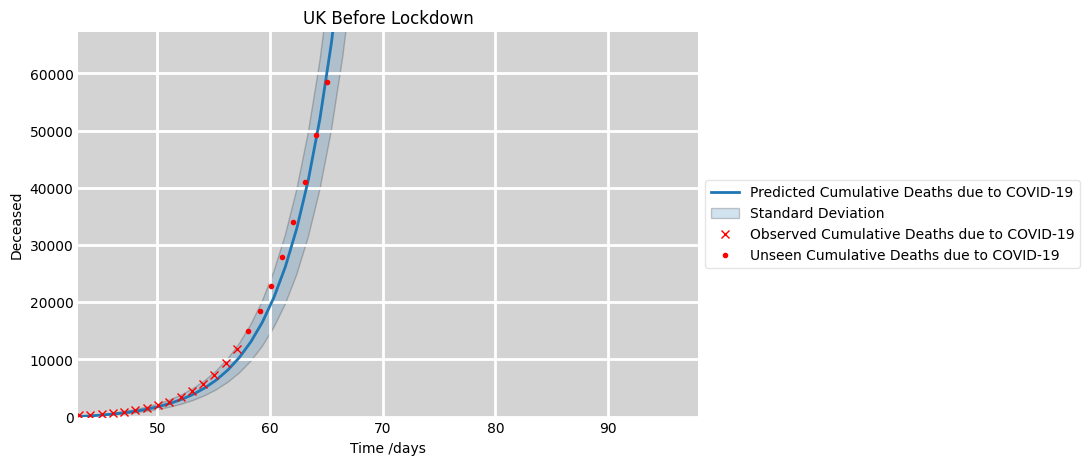

In [34]:
country_names = ['Netherlands', 'France','Germany','Italy','Spain','UK']
for country in country_names:
    fig, ax1 = plt.subplots(1,1, figsize=(8,5))    
    ax1.set_facecolor('lightgrey')
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    
    pop = dataset[country]['pop']
    startDate = dataset[country]['fLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']
    
    # before
    obvData_start = timeTot(firstDate,startDate)-10
    obvData_end = timeTot(firstDate,addTime(startDate,5))
    df = pd.read_csv('mcmc_data/'+country+"/fLock_before.csv")
    graph = plotSIRD(ax1,50, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+40], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)-10, False)
    ax1.set_title(country + " Before Lockdown")
    final_graph =plotRealData(ax1, realData, obvData_start, obvData_end, graph,0)
    plt.savefig('results/first_q/'+country+'.png')


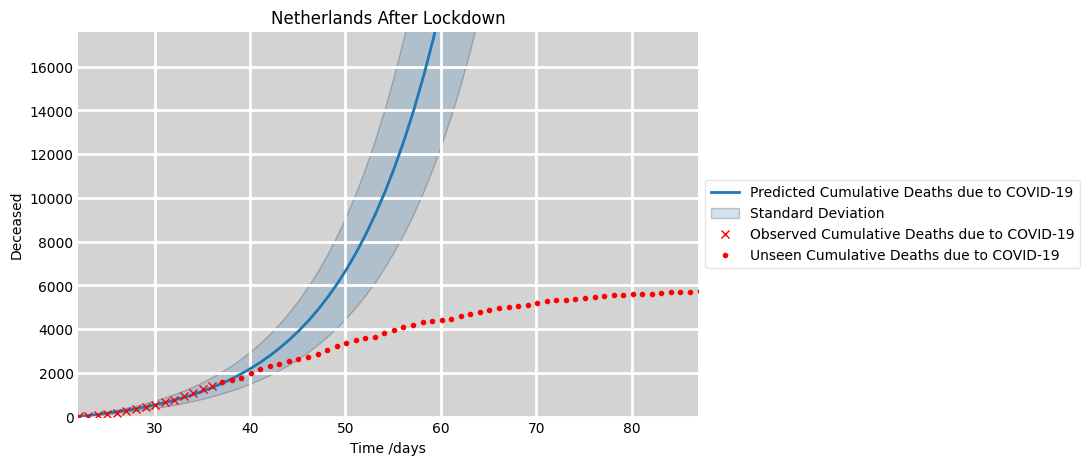

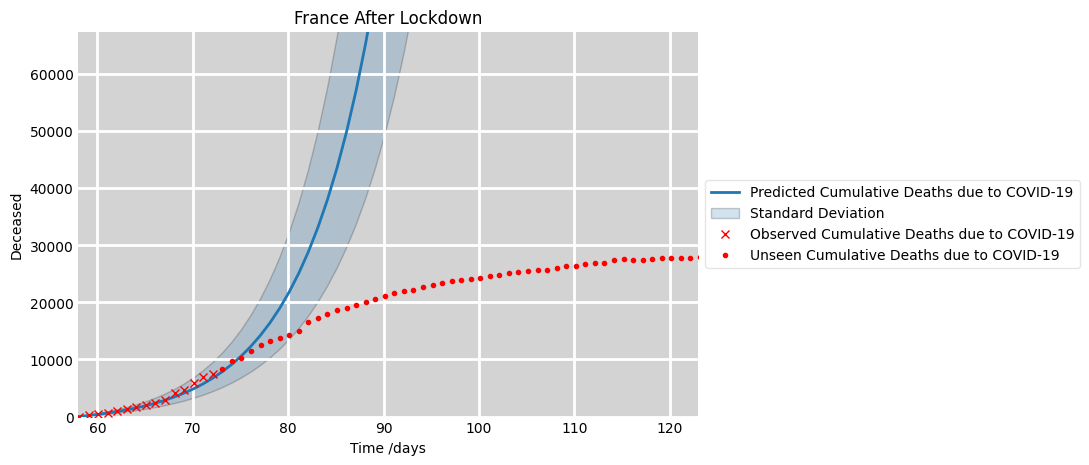

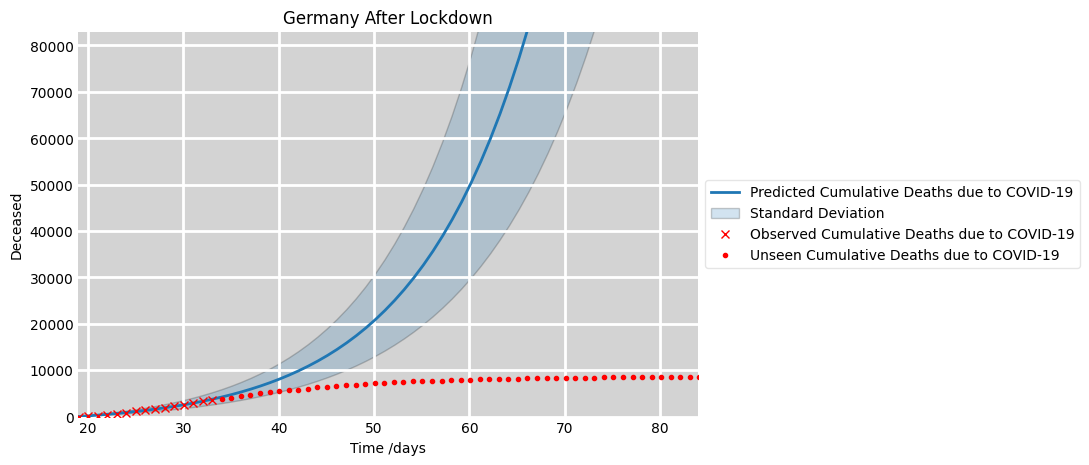

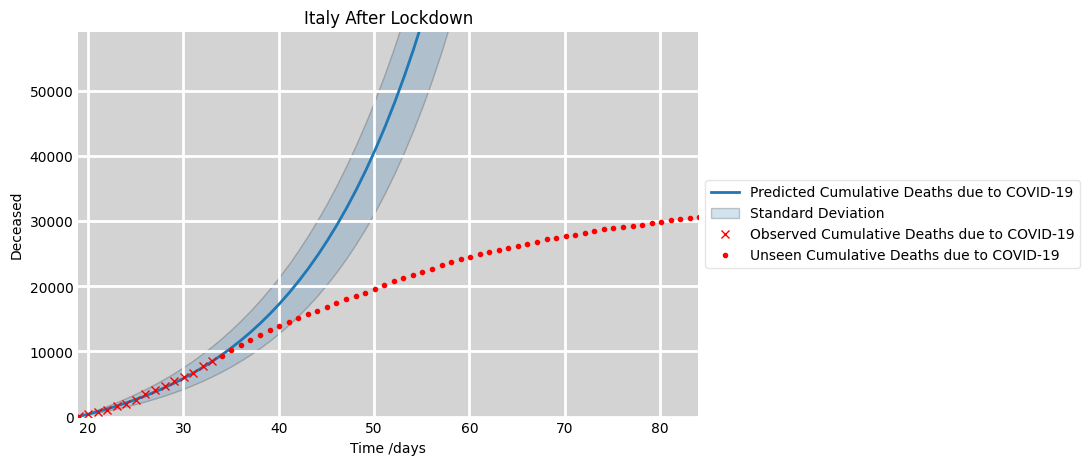

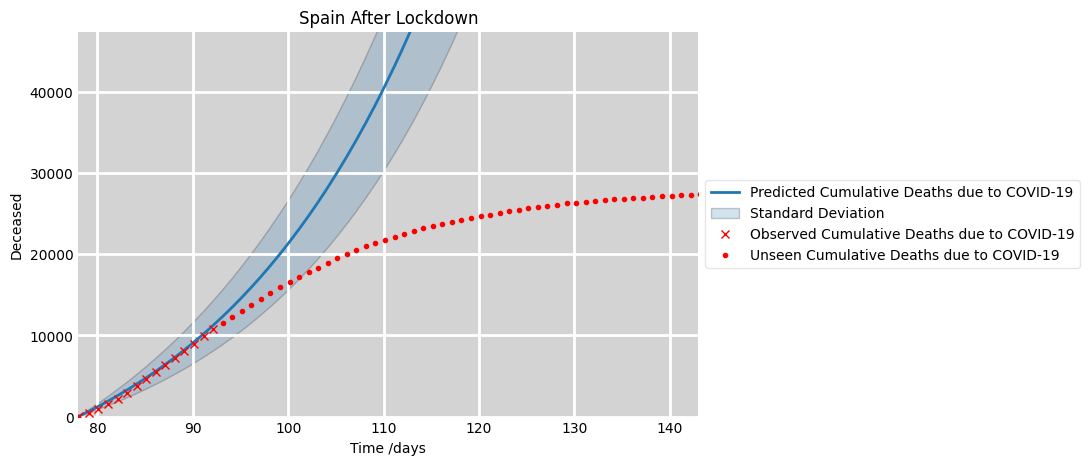

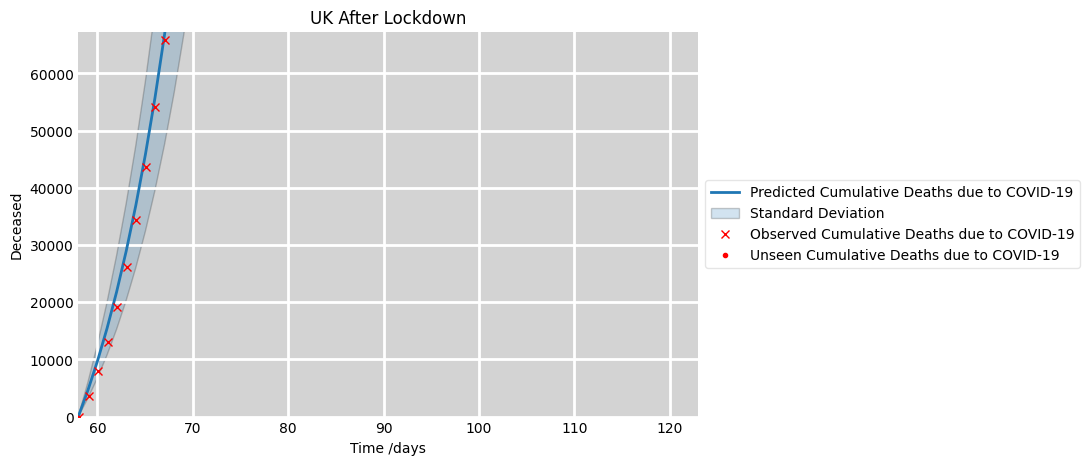

In [35]:
country_names = ['Netherlands', 'France','Germany','Italy','Spain','UK']
sird_deaths = {}
for country in country_names:
    fig, ax1 = plt.subplots(1,1, figsize=(8,5))    
    ax1.set_facecolor('lightgrey')
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    
    pop = dataset[country]['pop']
    startDate = dataset[country]['fLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']
    
    # before
    obvData_start = timeTot(firstDate,startDate)+5
    obvData_end = timeTot(firstDate,addTime(startDate,20))
    df = pd.read_csv('mcmc_data/'+country+"/fLock_after.csv")
    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+50], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)+5, False)
    sird_deaths[country] = {
        'deaths':graph,
        'date': obvData_end+30
    }
    ax1.set_title(country + " After Lockdown")
    final_graph =plotRealData(ax1, realData, obvData_start, obvData_end, graph,14,True)
    plt.savefig('results/first_q/'+country+'.png')

### Quantifying difference

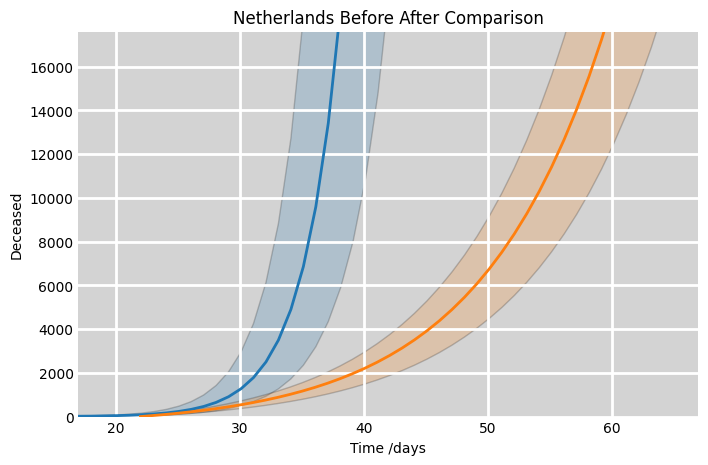

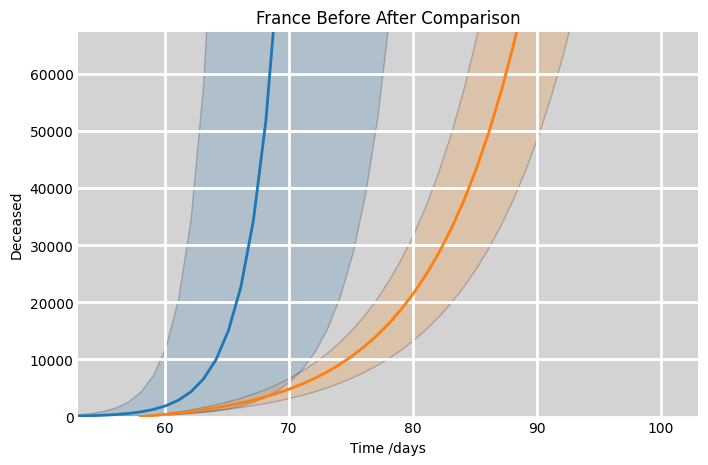

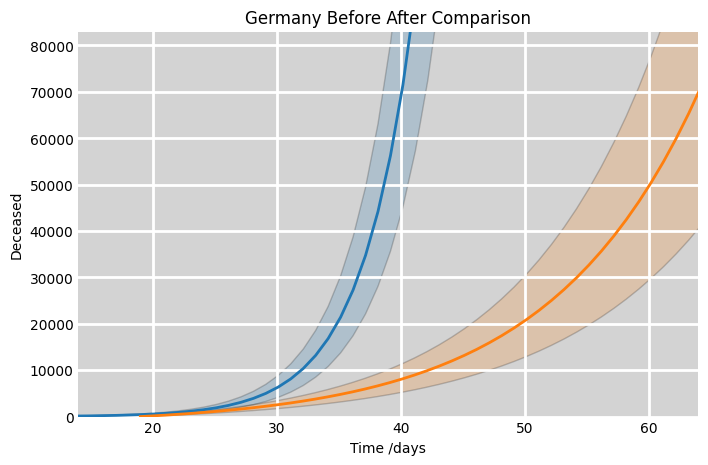

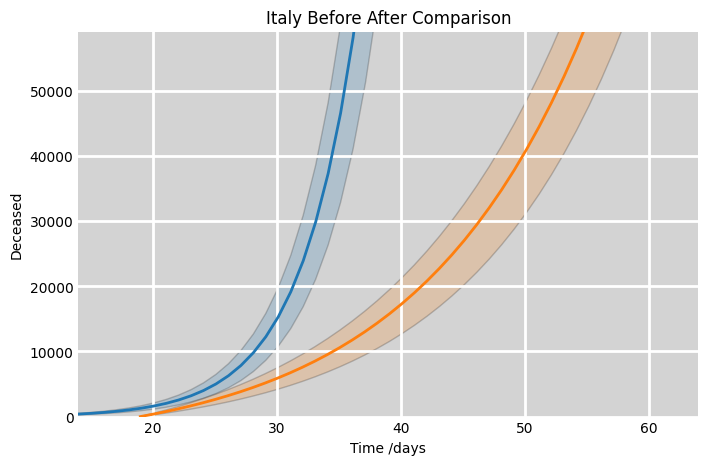

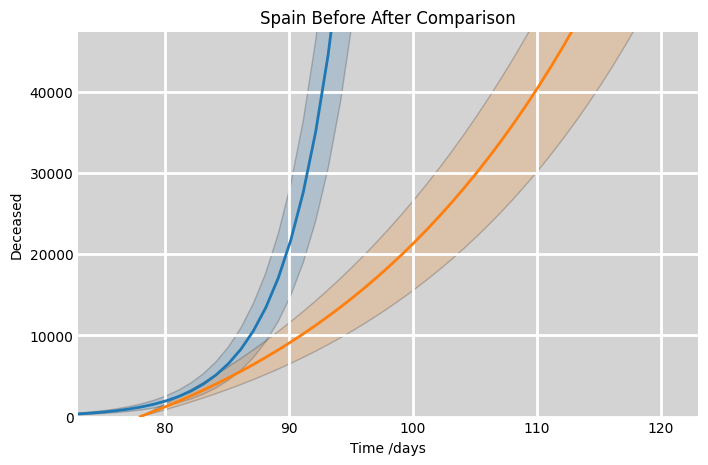

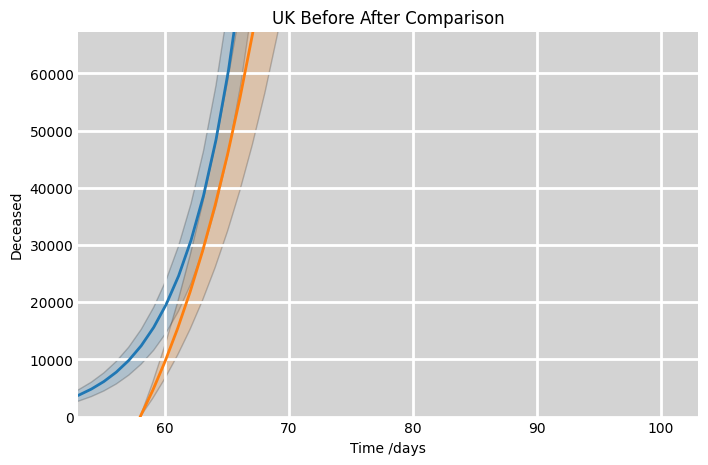

In [26]:
country_names = ['Netherlands', 'France','Germany','Italy','Spain','UK']
sird_deaths = {}
for country in country_names:
    fig, ax1 = plt.subplots(1,1, figsize=(8,5))    
    ax1.set_facecolor('lightgrey')
    
    pop = dataset[country]['pop']
    startDate = dataset[country]['fLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']
    offset=0
    # before
    obvData_start = timeTot(firstDate,startDate)
    obvData_end = timeTot(firstDate,addTime(startDate,0))
    df = pd.read_csv('mcmc_data/'+country+"/fLock_before.csv")
    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+50], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)-10, False)
    sird_deaths[country+str("_before")] = graph
    df = pd.read_csv('mcmc_data/'+country+"/fLock_after.csv")
    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+50], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)+5, False)
    sird_deaths[country+str("_after")] = graph
    ax1.set_title(country + " Before After Comparison")
    plt.savefig('results/first_q/'+country+'.png')

In [32]:
country_names = ['Netherlands', 'France','Germany','Italy','Spain','UK']
for country in country_names:
    print(country)
    print(sird_deaths[country+str("_before")][40])
    print(sird_deaths[country+str("_after")][30])
    print(100-(sird_deaths[country+str("_after")][30]/sird_deaths[country+str("_before")][40])*100)
    

Netherlands
328245.99360306095
8352.81726890928
97.45531783123296
France
6543858.936206153
65550.86321241916
98.99828428681835
Germany
185309.8444356661
19115.137016446824
89.68476981098378
Italy
339173.87642075476
37830.67687258075
88.84622917548911
Spain
468130.47370846773
36192.739533443804
92.26866406565466
UK
2717143.316301947
986621.5460186868
63.68901338036573
